In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
from scipy import stats

In [2]:
# If Surface fluxes are available
SF = False
HF_offset = 0# -5 #W/m2
FW_offset = 0# 0.5 #mm/day
tree_depth = 4

In [3]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
dt_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35

# Range of years of which 'early' and 'late' are defined

dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12+((-1850+1979)*12)
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12+((-1850+1979)*12)
range_yrs = init_late-init_early+1

weighted_months = np.array([31,28.25,31,30,31,30,31,31,30,31,30,31])


In [4]:
%%time
ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/*%i_bins_*.nc' %(tree_depth))

## Early Period
Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ACCESS_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')-273.15
V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ACCESS_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')-273.15
V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ACCESS_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ACCESS_BSP_data.Basin.values
# Sections = ACCESS_BSP_data.Section.values


CPU times: user 747 ms, sys: 75 ms, total: 822 ms
Wall time: 1.11 s


In [5]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

print(np.nansum(T_1*Vol_1))

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

print(np.nansum(T_1*Vol_1))

6.364193088105885e+18
6.364193088105885e+18


In [6]:
print(np.nansum(T_1*Vol_1), np.nansum(T_2*Vol_2))

6.364193088105885e+18 6.423879524901157e+18


In [7]:
print(np.nansum(CT_early.values.flatten()*Vol_1))

6.364193088105885e+18


In [8]:
HF_offset_W = HF_offset*ACCESS_BSP_data.A_sum #W
FW_offset_kg_s = FW_offset*ACCESS_BSP_data.A_sum*rho/(1000*24*3600) #kg/s

In [9]:
# if not SF:
#     # Fit a linear trend to the time series
#     trend_coefficients_hfds = np.zeros((Basins.size,2**tree_depth))
#     trend_coefficients_wfo = np.zeros((Basins.size,2**tree_depth))
#     for i in range(Basins.size):
#         for j in range(2**tree_depth):
#             trend_coefficients_hfds[i,j] = stats.linregress(dt.average_DT.isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').values,\
#                 (ACCESS_BSP_data.hfds_sum*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).values[i,:,j]).slope
#             trend_coefficients_wfo[i,j] = stats.linregress(dt.average_DT.isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').values,\
#                 (ACCESS_BSP_data.wfo_sum*dt.average_DT).isel(Time=slice(Early_period[0],Late_period[1])).values[i,:,j]).slope
#     W_m2_hfds_trend = trend_coefficients_hfds/A_early.values
#     mm_day_wfo_trend = trend_coefficients_wfo/(A_early.values*rho)*1000*24*3600

In [10]:
## Load SF data here, if provided
if SF:
    # ## Calculate the cumulative time integrated surface fluxes 
    # HFDS_cumsum = ((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=-1) # units: J
    # WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=-1) # units: kg

    # ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    # dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))
    # dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs))

    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=-1))\
        -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
    WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=-1)\
         -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))


    ## Get it in W/m2 and mm/day
    dhfds_flux = dhfds/(range_yrs*yr2sec*A_early)
    dwfo_flux = dwfo/(range_yrs*yr2sec*A_early*rho)*1000*24*3600

    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_early) # Is Vlate the right choice here? # units: C
    dS_wfo = -dwfo*S0/(rho*V_early) # Is Vlate the right choice here? # units: g/kg

    time = ACCESS_BSP_data.Time.values    

    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0

In [11]:

data_ACCESS_wfo = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/wfo_ACCESS_hist_proper.nc') ## hfds: Wm^-2; wfo: kgm^-2s^-1
data_ACCESS_hfds = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/hfds_ACCESS_hist_proper.nc') ## hfds: Wm^-2; wfo: kgm^-2s^-1
data_ACCESS_dtime = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
if SF and HF_offset==0 and FW_offset==0:
    ## Calculate the cumulative time integrated surface fluxes 
    hfds_ACCESS_cumsum = (data_ACCESS_hfds.__xarray_dataarray_variable__*data_ACCESS_dtime.average_DT).\
        isel(time=slice(Early_period[0], Late_period[-1])).cumsum('time').isel(time=-1) # UNITS: [J/m2]
    wfo_ACCESS_cumsum = (data_ACCESS_wfo.pme_river*data_ACCESS_dtime.average_DT).\
        isel(time=slice(Early_period[0], Late_period[-1])).cumsum('time').isel(time=-1) # UNITS: [kg/m2]

    hfds_ACCESS = hfds_ACCESS_cumsum*((np.mean(Late_period-Early_period[0])-np.mean(Early_period-Early_period[0]))/(Late_period[-1]-dyrs-Early_period[0]))*(1/(range_yrs*yr2sec)) # UNITS: [W/m2]
    wfo_ACCESS_kg_m2_s = wfo_ACCESS_cumsum*((np.mean(Late_period-Early_period[0])-np.mean(Early_period-Early_period[0]))/(Late_period[-1]-dyrs-Early_period[0]))*(1/(range_yrs*yr2sec)) # UNITS: [kg/m2/s]
    wfo_ACCESS = wfo_ACCESS_kg_m2_s/(rho)*24*3600*1000 # UNITS: mm/day

    hfds_ACCESS.load()
    wfo_ACCESS.load()

In [12]:
Opt_result = xr.open_mfdataset('../Optimisation_results/ACCESS_CM2_no_known_Q_prior_transports.nc')

RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')
    
mean_MOC_RAPID = RAPID_example.moc_mar_hc10.mean('time').values

In [13]:
ACCESS_mapped_masks = xr.open_mfdataset('../Masks_processed/ACCESS_mask_%i_bins_7*.nc' %(tree_depth))

if tree_depth<=4:
    fuzz_combined = (ACCESS_mapped_masks.salt.isel(time=slice(Early_period[0]-1440,Early_period[1]-1440)).sum('time')/(dyrs*12)).values
else:
    fuzz_combined = (ACCESS_mapped_masks.salt.sum('time')/(dyrs*12)).values

mask_ACCESS_xr = xr.open_mfdataset('../Basin_mask/mask_ACCESS.nc')

mask_ACCESS = (mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0).values)
## Load SF data here, if provided
if SF:
    dhfds_flux_vals = dhfds_flux.values
    dwfo_flux_vals = dwfo_flux.values

dS_adj = Opt_result.dS_adjustment.values.reshape(Basins.size,SA_late.shape[-1])
dT_adj = Opt_result.dT_adjustment.values.reshape(Basins.size,SA_late.shape[-1])

dwfo_adj = -dS_adj*(rho*V_late.values)/S0 # units: kg # swapped from V_early
dhfds_adj = dT_adj*(Cp*rho*V_late.values) # units: J # swapped from V_early

## Get it in W/m2 and mm/day
dhfds_flux_adj = dhfds_adj/(range_yrs*yr2sec*A_late.values) # swapped from V_early
dwfo_flux_adj = dwfo_adj/(range_yrs*yr2sec*A_late.values*rho)*1000*24*3600 # swapped from V_early

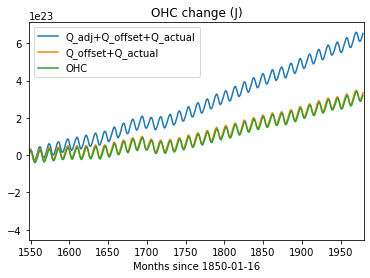

In [14]:
((ACCESS_BSP_data.hfds_sum+HF_offset_W+dhfds_flux_adj*A_late)*dt.average_DT).isel(Time=slice(Early_period[0], Late_period[1])).cumsum('Time').sum('Basin').sum('Depth').plot(label='Q_adj+Q_offset+Q_actual')
((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).isel(Time=slice(Early_period[0], Late_period[1])).cumsum('Time').sum('Basin').sum('Depth').plot(label='Q_offset+Q_actual')
((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).sum('Basin').sum('Depth'))-(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).sum('Basin').sum('Depth').isel(Time=Early_period[0]))).plot(label='OHC')

plt.title('OHC change (J)')
plt.xlabel('Months since 1850-01-16')
plt.xlim(Early_period[0], Late_period[1])
# plt.ylim(-1e23,3e24)
plt.legend()
plt.show()


In [15]:
if SF:
        hfds_tot = 0
        wfo_tot = 0
        for i in (range(SA_early.shape[-1])):
                tmp_dhfds = 0
                tmp_dwfo = 0
                for j in range(Basins.size):
                        tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_vals[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dhfds = tmp+tmp_dhfds
                        tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_vals[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dwfo = tmp+tmp_dwfo
                hfds_tot = tmp_dhfds+hfds_tot
                wfo_tot = tmp_dwfo+wfo_tot
dS_adj_tot = 0
dT_adj_tot = 0
for i in (range(SA_early.shape[-1])):
    tmp_dS_adj = 0
    tmp_dT_adj = 0
    for j in range(Basins.size):
            tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dS_adj = tmp+tmp_dS_adj
            tmp = mask_ACCESS[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dT_adj = tmp+tmp_dT_adj
    dS_adj_tot = tmp_dS_adj+dS_adj_tot
    dT_adj_tot = tmp_dT_adj+dT_adj_tot

In [16]:
lats = data_ACCESS_hfds.geolat_t.values
lons = data_ACCESS_hfds.geolon_t.values

In [17]:
if SF and HF_offset==0 and FW_offset==0:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -150,150

    hfds_ACCESS.plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)


    ax2.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -8,8
    wfo_ACCESS.plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)


    ax4.pcolormesh(lons, lats, wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

    ax1.set_title('Regular Grid')
    ax2.set_title('Remapped')
    ax3.set_title('')
    # ax4.set_title('Accumulated P-E+R (Remapped)')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('../Figures/net_hfds_wfo_ACCESS.png', bbox_inches='tight', dpi=300)

In [18]:
if SF and HF_offset==0 and FW_offset==0:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -150,150

    ax1.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())


    ax2.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -8,8

    ax3.pcolormesh(lons, lats, wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

    ax4.pcolormesh(lons, lats, dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

    ax1.set_title('$Q_i^{prior}$')
    ax2.set_title('$Q_j^{adjust}$')
    ax3.set_title('')
    # ax4.set_title('Accumulated P-E+R (Remapped)')
 
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('../Figures/hfds_wfo_adj_vs_actual_ACCESS.png', bbox_inches='tight', dpi=300)
    plt.show()

In [19]:
if SF and HF_offset==0 and FW_offset==0:
    print(np.std(dhfds_flux_adj[np.isfinite(dhfds_flux_adj)]))
    print(np.std(dwfo_flux_adj[np.isfinite(dwfo_flux_adj)]))
    print(np.std(hfds_tot[np.isfinite(hfds_tot)]))
    print(np.std(wfo_tot[np.isfinite(wfo_tot)]))

In [20]:
if SF and (HF_offset!=0 or FW_offset!=0):
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,3)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4, ax5, ax6 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[0,2], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,2], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -abs(HF_offset),abs(HF_offset)

    ax1.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*HF_offset, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())


    ax2.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax3.pcolormesh(lons, lats,  dT_adj_tot/dT_adj_tot*HF_offset+dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -abs(FW_offset),abs(FW_offset)

    ax4.pcolormesh(lons, lats, dT_adj_tot/dT_adj_tot*FW_offset, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

    ax5.pcolormesh(lons, lats, dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

    ax6.pcolormesh(lons, lats, dT_adj_tot/dT_adj_tot*FW_offset+dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())


    ax1.set_title('$bias$')
    ax2.set_title('$Q_j^{adjust}$')
    ax3.set_title('$bias+Q_j^{adjust}$')
 
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
    ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))
    ax6.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=1))

    cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('../Figures/hfds_wfo_adj_vs_offset_ACCESS.png', bbox_inches='tight', dpi=300)
    plt.show()

In [21]:
if SF and (HF_offset!=0 or FW_offset!=0):
    print(np.std((dT_adj_tot/dT_adj_tot*FW_offset+dS_adj_tot)[np.isfinite(dT_adj_tot/dT_adj_tot*FW_offset+dS_adj_tot)]))
    print(np.std((dT_adj_tot/dT_adj_tot*HF_offset+dT_adj_tot)[np.isfinite(dT_adj_tot/dT_adj_tot*HF_offset+dT_adj_tot)]))

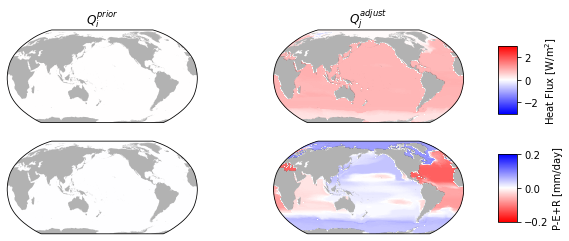

In [22]:
if not SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -3,3
    
    ax1.pcolormesh(lons, lats,  dT_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax2.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.93,0.57, 0.03, 0.25])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -.2,.2

    ax3.pcolormesh(lons, lats,  dS_adj_tot*0, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

    ax4.pcolormesh(lons, lats, dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree())

    ax1.set_title('$Q_i^{prior}$')
    ax2.set_title('$Q_j^{adjust}$')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.93, 0.17, 0.03, 0.25])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('../Figures/hfds_wfo_adj_freerun_ACCESS.png', bbox_inches='tight', dpi=300)
    plt.show()

______
